In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

import numpy as np
import theano

In [3]:
from carl.distributions import Join
from carl.distributions import Mixture
from carl.distributions import Normal
from carl.distributions import Exponential
from carl.distributions import LinearTransform
from sklearn.datasets import make_sparse_spd_matrix

# Parameters
true_A = 1.
true_B = -1.
A = theano.shared(true_A, name="A")
B = theano.shared(true_B, name="B")

# Build simulator
R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7)

p0 = LinearTransform(Join(components=[
        Normal(mu=A, sigma=1),
        Normal(mu=B, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

# Define p1 at fixed arbitrary value theta1 := 0,0
p1 = LinearTransform(Join(components=[
        Normal(mu=0, sigma=1),
        Normal(mu=0, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

# Draw data
X_true = p0.rvs(1000, random_state=777) 

In [4]:
# Projection operator
print(R)

[[ 1.31229955  0.10499961  0.48310515 -0.3249938  -0.26387927]
 [ 0.10499961  1.15833058 -0.55865473  0.25275522 -0.39790775]
 [ 0.48310515 -0.55865473  2.25874579 -0.52087938 -0.39271231]
 [-0.3249938   0.25275522 -0.52087938  1.4034925  -0.63521059]
 [-0.26387927 -0.39790775 -0.39271231 -0.63521059  1.        ]]


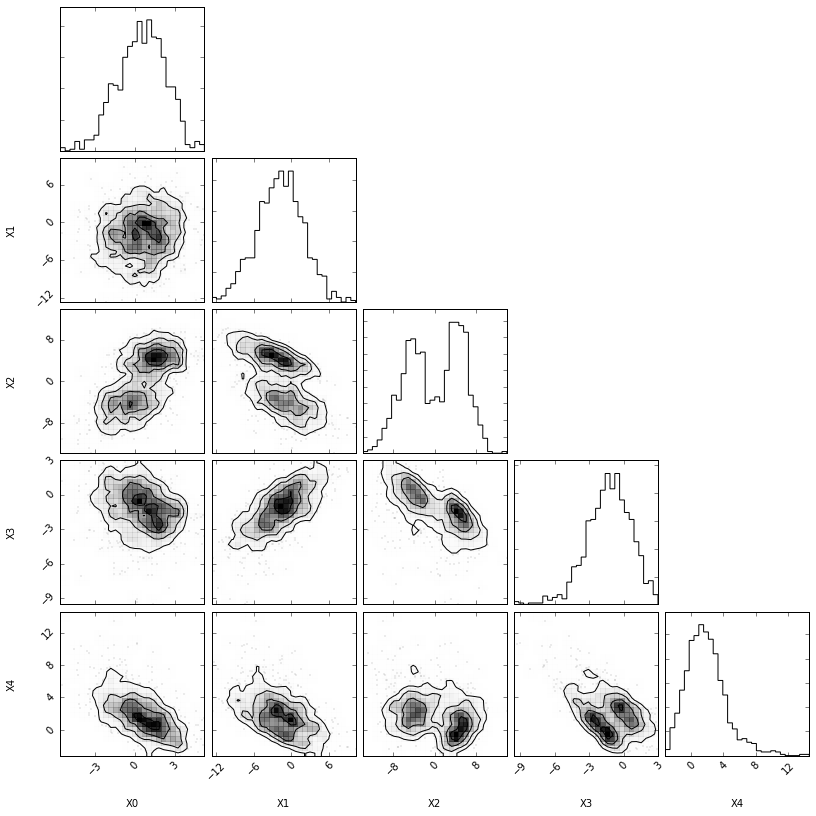

In [9]:
import corner
fig = corner.corner(X_true, bins=30, smooth=0.75, labels=["X0", "X1", "X2", "X3", "X4"])

# Known likelihood setup

In [6]:
from scipy.optimize import minimize

def nll_true(theta, X):
    A.set_value(theta[0])
    B.set_value(theta[1])
    return (p0.nnlf(X) - p1.nnlf(X)).sum()

r = minimize(nll_true, x0=[0, 0], args=(X_true,))
true_MLE = r.x

print("True MLE =", true_MLE)

True MLE = [ 0.95075776 -1.06817031]


In [19]:
# True contours
A.set_value(true_A)
B.set_value(true_B)

bounds = [(true_MLE[0] - 0.12, true_MLE[0] + 0.12),
          (true_MLE[1] - 0.35, true_MLE[1] + 0.35)]

As = np.linspace(*bounds[0], 100)
Bs = np.linspace(*bounds[1], 100)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

true_contours = np.zeros(len(X))

i = 0
for a in As:
    for b in Bs:
        true_contours[i] = nll_true([a, b], X_true)
        i += 1
        
true_contours = 2. * (true_contours - r.fun)

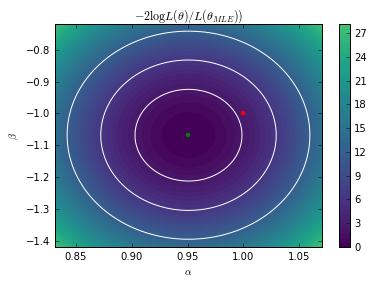

In [33]:
from scipy.stats import chi2
plt.contour(As, Bs, true_contours.reshape(AA.shape).T, 
            levels=[chi2.ppf(0.683, df=2), 
                    chi2.ppf(0.9545, df=2),
                    chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, true_contours.reshape(AA.shape).T, 50, vmin=0, vmax=40)
cb = plt.colorbar()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.plot([true_MLE[0]], [true_MLE[1]], "g.", markersize=8)
plt.plot([true_A], [true_B], "r.", markersize=8)
plt.axis((*bounds[0], *bounds[1]))
plt.title(r"$-2 \log L(\theta) / L(\theta_{MLE}))$")
plt.show()

# Likelihood-free setup

In [22]:
# Build classification data
from carl.learning import make_parameterized_classification

bounds = [(-3, 3), (-3, 3)]

X, y = make_parameterized_classification(
    p0, p1,
    1000000, 
    [(A, np.linspace(*bounds[0], num=30)), 
     (B, np.linspace(*bounds[1], num=30))],
    random_state=1)

In [23]:
# Train parameterized classifier
from carl.learning import as_classifier
from carl.learning import make_parameterized_classification
from carl.learning import ParameterizedClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

clf = ParameterizedClassifier(
    make_pipeline(StandardScaler(), 
                  as_classifier(MLPRegressor(learning_rate="adaptive", 
                                             hidden_layer_sizes=(40, 40),
                                             tol=1e-6,
                                             random_state=0))),
    [A, B])
clf.fit(X, y)

/home/gilles/src/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


ParameterizedClassifier(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('wrapper', Wrapper(base_estimator=MLPRegressor(activation='relu', algorithm='adam', alpha=0.0001,
       batch_size=200, beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(40,...
       shuffle=True, tol=1e-06, validation_fraction=0.1, verbose=False,
       warm_start=False)))]),
            params=[A, B])

In [24]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

def objective(theta, random_state=0, n_trials=1):    
    print(theta)
    # Set parameter values   
    A.set_value(theta[0])
    B.set_value(theta[1])
    
    s = 0.
    
    for n in range(n_trials):
        # Fit ratio
        ratio = ClassifierRatio(CalibratedClassifierCV(
            base_estimator=clf, 
            cv="prefit",  # keep the pre-trained classifier
            method="histogram", bins=50))

        X0 = p0.rvs(n_samples=100000)
        X1 = p1.rvs(n_samples=100000, random_state=random_state)
        X = np.vstack((X0, X1))
        y = np.zeros(len(X))
        y[len(X0):] = 1

        ratio.fit(X, y)

        #ratio.fit(numerator=p0, denominator=p1, n_samples=100000)

        # Evaluate log-likelihood ratio
        r = ratio.predict(X_true, log=True)
        value = -np.mean(r[np.isfinite(r)])  # optimization is more stable using mean
                                             # this will need to be rescaled by len(X_true)    
            
        s += value
            
    return s / n_trials

In [25]:
from GPyOpt.methods import BayesianOptimization
bounds = [(-3, 3), (-3, 3)]
solver = BayesianOptimization(vectorize(objective), bounds)
solver.run_optimization(max_iter=50, true_gradients=False)

[ 0.97327058  0.806869  ]
[-1.92918413 -1.56554796]
[-1.88614368  1.26514921]
[-1.87151537  0.52976397]
[ 1.56890726  1.99440319]
[ 0.03169316  1.53856424]
[ 3. -3.]
[ 3.          0.01276896]
[ 0.9001818   1.18530922]
[ 0.87271185 -0.51907793]
[ 0.72768948 -2.81131981]
[ 0.92023721 -1.12414929]
[ 0.89466595 -1.33462335]
[ 0.62891601 -0.99997693]
[ 0.72117176 -1.06093959]
[ 0.60357224  1.98482433]
[ 0.64362503 -1.21624353]
[ 0.8221266  -1.32734098]
[ 0.83984926 -0.72981217]
[ 1.17920884 -1.56978235]
[ 0.63622768 -1.32274962]
[ 0.67129523 -1.14531542]
[ 0.70063009 -0.69581925]
[ 0.82884789 -0.84690283]
[ 0.91358276 -0.70793496]
[ 0.94728731 -1.69676976]
[-1.51172715  2.74263473]
[ 1.12273877 -1.02946846]
[ 0.82550173 -1.46566771]
[ 0.92978712 -1.07211191]
[ 0.84109931 -1.44977206]
[ 0.83649996 -0.53513042]
[-1.72268553  0.99034384]
[ 1.72438796 -2.9853071 ]
[ 2.99883107  2.93758721]
[ 0.86557541 -0.81833171]
[ 0.89638759 -0.92267065]
[ 0.91529052 -0.85367591]
[-0.08043433 -2.88988559]
[ 

1

In [26]:
est_MLE = solver.x_opt
print("Estimated MLE =", est_MLE)

Estimated MLE = [ 0.93486363 -1.25851282]


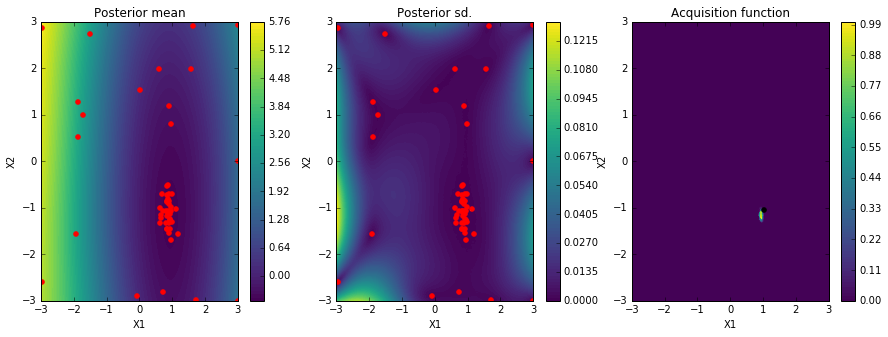

In [27]:
solver.plot_acquisition()

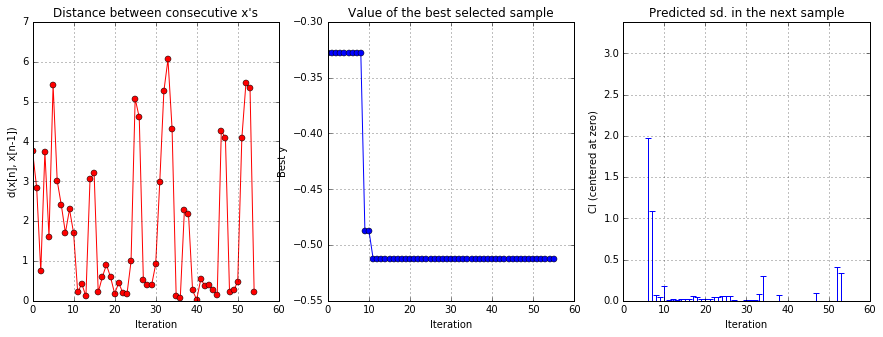

In [28]:
solver.plot_convergence()

In [29]:
def gp_objective(theta):
    theta = theta.reshape(1, -1)
    return solver.model.predict(theta)[0][0]

r = minimize(gp_objective, x0=[0,0])
gp_MLE = r.x

print("GP MLE =", gp_MLE)

GP MLE = [ 0.93416013 -1.1564249 ]


In [30]:
A.set_value(true_A)
B.set_value(true_B)

bounds = [(true_MLE[0] - 0.12, true_MLE[0] + 0.12),
          (true_MLE[1] - 0.35, true_MLE[1] + 0.35)]

As = np.linspace(*bounds[0], 100)
Bs = np.linspace(*bounds[1], 100)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

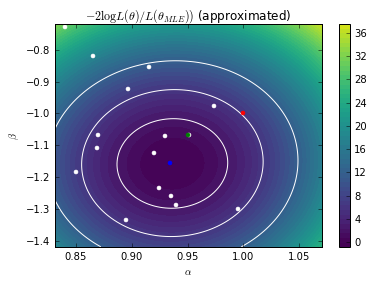

In [32]:
from scipy.stats import chi2
gp_contours, _= solver.model.predict(X)
gp_contours = 2. * (gp_contours - r.fun) * len(X_true)  # Rescale

cs = plt.contour(As, Bs, gp_contours.reshape(AA.shape), 
                 levels=[chi2.ppf(0.683, df=2), 
                         chi2.ppf(0.9545, df=2),
                         chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, gp_contours.reshape(AA.shape), 50, vmin=0, vmax=40)
cb = plt.colorbar()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.plot(solver.X[:,0], solver.X[:,1], 'w.', markersize=8)
plt.plot([true_A], [true_B], "r.", markersize=8)
plt.plot([gp_MLE[0]], [gp_MLE[1]], "b.", markersize=8)
plt.plot([true_MLE[0]], [true_MLE[1]], "g.", markersize=8)
plt.axis((*bounds[0], *bounds[1]))
plt.title(r"$-2 \log L(\theta) / L(\theta_{MLE}))$ (approximated)")
plt.show()

---

In [34]:
# Scanned contours
A.set_value(true_A)
B.set_value(true_B)

# bounds = [(true_MLE[0] - 1, true_MLE[0] + 1), 
#           (true_MLE[1] - 1, true_MLE[1] + 1)]

bounds = [(true_MLE[0] - 0.12, true_MLE[0] + 0.12),
          (true_MLE[1] - 0.35, true_MLE[1] + 0.35)]

As = np.linspace(*bounds[0], 15)
Bs = np.linspace(*bounds[1], 15)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

scan_contours = np.zeros(len(X))

i = 0
for a in As:    
    for b in Bs:
        scan_contours[i] = objective([a, b], n_trials=10)  # average over 10 trials
        i += 1

[0.83075776025457915, -1.4181703123481033]
[0.83075776025457915, -1.3681703123481033]
[0.83075776025457915, -1.3181703123481032]
[0.83075776025457915, -1.2681703123481034]
[0.83075776025457915, -1.2181703123481034]
[0.83075776025457915, -1.1681703123481033]
[0.83075776025457915, -1.1181703123481035]
[0.83075776025457915, -1.0681703123481034]
[0.83075776025457915, -1.0181703123481034]
[0.83075776025457915, -0.96817031234810336]
[0.83075776025457915, -0.91817031234810342]
[0.83075776025457915, -0.86817031234810349]
[0.83075776025457915, -0.81817031234810345]
[0.83075776025457915, -0.7681703123481034]
[0.83075776025457915, -0.71817031234810347]
[0.84790061739743627, -1.4181703123481033]
[0.84790061739743627, -1.3681703123481033]
[0.84790061739743627, -1.3181703123481032]
[0.84790061739743627, -1.2681703123481034]
[0.84790061739743627, -1.2181703123481034]
[0.84790061739743627, -1.1681703123481033]
[0.84790061739743627, -1.1181703123481035]
[0.84790061739743627, -1.0681703123481034]
[0.847

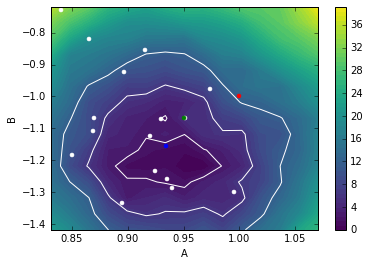

In [35]:
c = 2 * (scan_contours - scan_contours.min()) * len(X_true)  # or -solver.fx_opt?

plt.contour(As, Bs, c.reshape(AA.shape).T, 
            levels=[chi2.ppf(0.683, df=2), 
                    chi2.ppf(0.9545, df=2),
                    chi2.ppf(0.9973, df=2)], colors=["w"])
plt.contourf(As, Bs, c.reshape(AA.shape).T, 50, vmin=0, vmax=40)
plt.colorbar()
plt.xlabel("A")
plt.ylabel("B")
plt.plot(solver.X[:,0], solver.X[:,1], 'w.', markersize=8)
plt.plot([true_A], [true_B], "r.", markersize=8)
plt.plot([gp_MLE[0]], [gp_MLE[1]], "b.", markersize=8)
plt.plot([true_MLE[0]], [true_MLE[1]], "g.", markersize=8)
plt.axis((*bounds[0], *bounds[1]))
plt.show()

In [ ]:
def fit_and_plot(theta):
    # Set parameter values   
    A.set_value(theta[0])
    B.set_value(theta[1])

    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=50))

    X0 = p0.rvs(n_samples=100000)
    X1 = p1.rvs(n_samples=100000, random_state=0)
    X = np.vstack((X0, X1))
    y = np.zeros(len(X))
    y[len(X0):] = 1

    ratio.fit(X, y)
    r = ratio.predict(X_true, log=True)
    print(-np.mean(r[np.isfinite(r)]), -np.mean(r[np.isfinite(r)]) * len(X_true), np.isfinite(r).sum())
    
    c = ratio.classifier_.classifiers_[0]
    h = ratio.classifier_.calibrators_[0][0]
    reals = np.linspace(0, 1, num=100)
    plt.plot(reals, h.pdf(reals.reshape(-1, 1)))   
    h = ratio.classifier_.calibrators_[0][1]
    reals = np.linspace(0, 1, num=100)
    plt.plot(reals, h.pdf(reals.reshape(-1, 1)))
    plt.show()
    
    plt.hist(r[np.isfinite(r)], bins=50)
    plt.show()
    

In [ ]:
fit_and_plot([true_A, true_B])
fit_and_plot([true_A, true_B])